Running...
Completed Iterations:  0
Completed Iterations:  100
Completed Iterations:  200
Completed Iterations:  300
Completed Iterations:  400
Completed Iterations:  500
Completed Iterations:  600
Completed Iterations:  700
Completed Iterations:  800
Completed Iterations:  900
Completed Iterations:  1000
Completed Iterations:  1100
Completed Iterations:  1200
Completed Iterations:  1300
Completed Iterations:  1400
Completed Iterations:  1500
Completed Iterations:  1600
Completed Iterations:  1700
Completed Iterations:  1800
Completed Iterations:  1900
Execution time: 25.45587396621704 seconds


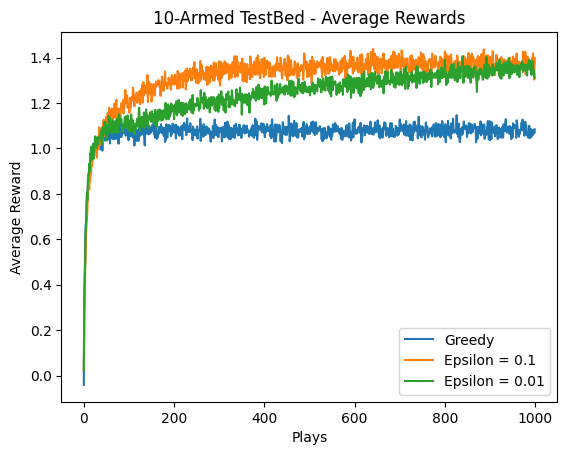

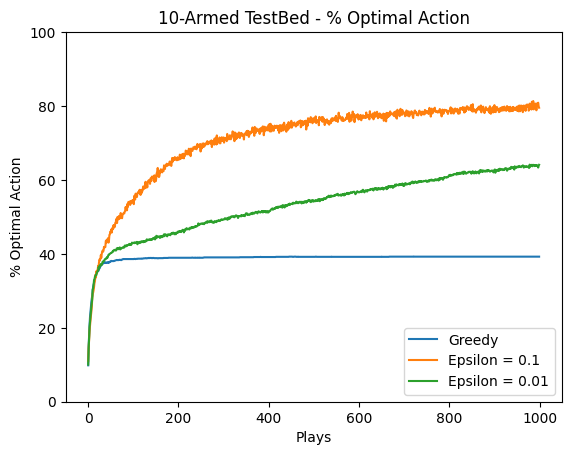

In [1]:
'''
###############################################################################################
    10-Armed Testbed (Reinforcement Learning: An Introduction, Sutton, Barto, fig 2.2)
    Created by Jet-Tsyn Lee 23/02/18, last update 03/01/18

    Program is to compare the greedy and e-greedy methods in a 10-armed bandit testbed, presented
    in the Reinforcement Learning: An Introduction book, Sutton, Barto, fig 2.2.
###############################################################################################
'''
import numpy as np
import matplotlib.pyplot as plt
import time

################################################################
# TestBed class containing the states and actions, and the overall rules of the test
class Testbed(object):

    # Constructor
    def __init__(self, nArms, mean, stDev):

        # Number of arms
        self.nArms = nArms

        # Used for the Gaussian random actions
        self.mean = mean        # Mean
        self.stDev = stDev      # Standard Deviation

        self.actArr = np.zeros(nArms)   # Array to store action values
        self.optim = 0                  # Store optimal value for greedy
        self.reset()                    

    # Reset testbed for next iteration
    def reset(self):
        # Set random gaussian/normal values using numpy function, requires mean, standard deviation and number of arms
        self.actArr = np.random.normal(self.mean, self.stDev, self.nArms)

        # Identify the maximum value in action array
        self.optim = np.argmax(self.actArr)


################################################################
# Agent Class - Controls the agents movement and behaviour in the environment interacting with the testbed
# and receives information on the current position
class Agent(object):

    # Constructor
    def __init__(self,nArms, eProb=0):
        self.nArms = nArms      # Number of arms
        self.eProb = eProb      # Epsilon probability

        self.timeStep = 0                    # Time Step t
        self.lastAction = None               # Store last action

        self.kAction = np.zeros(nArms)          # count of actions taken at time t
        self.rSum = np.zeros(nArms)             # Sums number of rewards
        self.valEstimates = np.zeros(nArms)     # action value estimates sum(rewards)/Amount


    # Return string for graph legend
    def __str__(self):
        if self.eProb == 0:
            return "Greedy"
        else:
            return "Epsilon = " + str(self.eProb)


    # Selects action based on a epsilon-greedy behaviour,
    # if epsilon equals zero, then the agent performs a greedy selection
    def action(self):

        ### POLICY ###
        # Epsilon method
        randProb = np.random.random()   # Pick random probability between 0-1
        if randProb < self.eProb:
            a = np.random.choice(len(self.valEstimates))    # Select random action

        # Greedy Method
        else:
            maxAction = np.argmax(self.valEstimates)     # Find max value estimate
            # identify the corresponding action, as array containing only actions with max
            action = np.where(self.valEstimates == np.argmax(self.valEstimates))[0]

            # If multiple actions contain the same value, randomly select an action
            if len(action) == 0:
                a = maxAction
            else:
                a = np.random.choice(action)

        # save last action in variable, and return result
        self.lastAction = a
        return a


    # Interpreter - updates the value extimates amounts based on the last action
    def interpreter(self, reward):
        # Add 1 to the number of action taken in step
        At = self.lastAction

        self.kAction[At] += 1       # Add 1 to action selection
        self.rSum[At] += reward     # Add reward to sum array

        # Calculate new action-value, sum(r)/ka
        self.valEstimates[At] = self.rSum[At]/self.kAction[At]

        # Increase time step
        self.timeStep += 1


    # Reset all variables for next iteration
    def reset(self):
        self.timeStep = 0                    # Time Step t
        self.lastAction = None               # Store last action

        self.kAction[:] = 0                  # count of actions taken at time t
        self.rSum[:] = 0
        self.valEstimates[:] = 0   # action value estimates Qt ~= Q*(a)


################################################################
# Environment class to control all objects (agent/Testbed)
class Environment(object):

    # Constructor
    def __init__(self, testbed, agents, plays, iterations):
        self.testbed = testbed
        self.agents = agents

        self.plays = plays
        self.iterations = iterations


    # Run Test
    def play(self):

        # Array to store the scores, number of plays X number of agents
        scoreArr = np.zeros((self.plays, len(self.agents)))
        # Array to maintain optimal count, Graph 2
        optimlArr = np.zeros((self.plays, len(self.agents)))

        # loop for number of iterations
        for iIter in range(self.iterations):

            # Print statement after every 100 iterations
            if (iIter%100) == 0:
                print("Completed Iterations: ",iIter)

            #Reset testbed and all agents
            self.testbed.reset()
            for agent in self.agents:
                agent.reset()


            # Loop for number of plays
            for jPlays in range(self.plays):
                agtCnt = 0

                for kAgent in self.agents:
                    actionT =  kAgent.action()

                    # Reward - normal dist (Q*(at), variance = 1)
                    rewardT = np.random.normal(self.testbed.actArr[actionT], scale=1)

                    # Agent checks state
                    kAgent.interpreter(reward=rewardT)

                    # Add score in arrary, graph 1
                    scoreArr[jPlays,agtCnt] += rewardT

                    # check the optimal action, add optimal to array, graph 2
                    if actionT == self.testbed.optim:
                        optimlArr[jPlays,agtCnt] += 1

                    agtCnt += 1

        #return averages
        scoreAvg = scoreArr/self.iterations
        optimlAvg = optimlArr/self.iterations

        return scoreAvg, optimlAvg


################################################################
## MAIN ##
if __name__ == "__main__":
    start_time = time.time()    #store time to monitor execution
    nArms = 10                  # n number of bandits
    iterations = 2000         # number of repeated iterations
    plays = 1000                # number of pplays per iteration

    # Setup objects to contain infomration about the agents, testbed, and environment
    testbed = Testbed(nArms=nArms,mean=0,stDev=1)
    agents = [Agent(nArms=nArms),Agent(nArms=nArms,eProb=0.1),Agent(nArms=nArms,eProb=0.01)]
    environment = Environment(testbed=testbed,agents=agents,plays=plays,iterations=iterations)

    # Run Environment
    print("Running...")
    g1Scores, g2Optimal = environment.play()
    print("Execution time: %s seconds" % (time.time() - start_time))


    #Graph 1 - Averate rewards over all plays
    plt.title("10-Armed TestBed - Average Rewards")
    plt.plot(g1Scores)
    plt.ylabel('Average Reward')
    plt.xlabel('Plays')
    plt.legend(agents, loc=4)
    plt.show()

    #Graph 1 - optimal selections over all plays
    plt.title("10-Armed TestBed - % Optimal Action")
    plt.plot(g2Optimal * 100)
    plt.ylim(0, 100)
    plt.ylabel('% Optimal Action')
    plt.xlabel('Plays')
    plt.legend(agents, loc=4)
    plt.show()


Running...
Completed Iterations:  0
Completed Iterations:  100
Completed Iterations:  200
Completed Iterations:  300
Completed Iterations:  400
Completed Iterations:  500
Completed Iterations:  600
Completed Iterations:  700
Completed Iterations:  800
Completed Iterations:  900
Completed Iterations:  1000
Completed Iterations:  1100
Completed Iterations:  1200
Completed Iterations:  1300
Completed Iterations:  1400
Completed Iterations:  1500
Completed Iterations:  1600
Completed Iterations:  1700
Completed Iterations:  1800
Completed Iterations:  1900
Execution time: 48.99351692199707 seconds


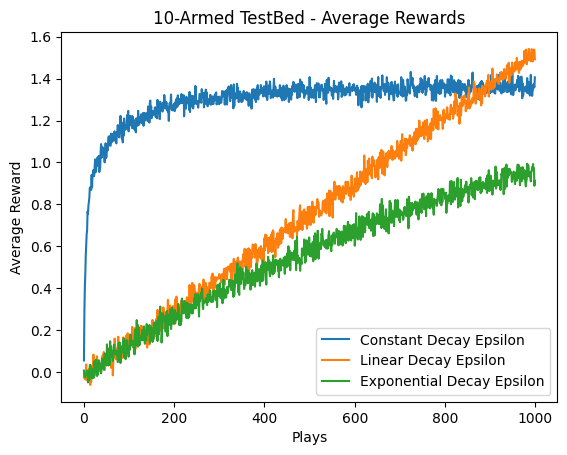

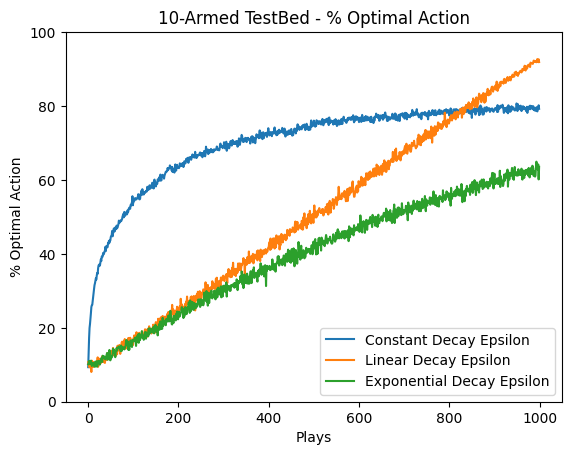

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

################################################################
# TestBed class containing the states and actions, and the overall rules of the test
class Testbed(object):

    # Constructor
    def __init__(self, nArms, mean, stDev):
        self.nArms = nArms
        self.mean = mean        # Mean
        self.stDev = stDev      # Standard Deviation
        self.actArr = np.zeros(nArms)   # Array to store action values
        self.optim = 0                  # Store optimal value for greedy
        self.reset()

    # Reset testbed for next iteration
    def reset(self):
        self.actArr = np.random.normal(self.mean, self.stDev, self.nArms)
        self.optim = np.argmax(self.actArr)

################################################################
# Agent Class - Controls the agents movement and behaviour in the environment interacting with the testbed
# and receives information on the current position
class Agent(object):

    # Constructor with decay types: 'linear', 'exponential', or 'constant'
    def __init__(self, nArms, eProb=0, decay_type='constant', initial_epsilon=1.0, final_epsilon=0.01, decay_rate=0.001):
        self.nArms = nArms      # Number of arms
        self.eProb = eProb      # Initial epsilon probability for constant decay
        self.initial_epsilon = initial_epsilon
        self.final_epsilon = final_epsilon
        self.decay_rate = decay_rate
        self.decay_type = decay_type
        self.timeStep = 0
        self.lastAction = None
        self.kAction = np.zeros(nArms)   # count of actions taken at time t
        self.rSum = np.zeros(nArms)      # Sums number of rewards
        self.valEstimates = np.zeros(nArms)  # action value estimates sum(rewards)/Amount

    # Return string for graph legend
    def __str__(self):
        return f"{self.decay_type.capitalize()} Decay Epsilon"

    # Linear epsilon decay
    def linear_epsilon_decay(self):
        epsilon = max(self.final_epsilon, self.initial_epsilon - self.decay_rate * self.timeStep)
        return epsilon

    # Exponential epsilon decay
    def exponential_epsilon_decay(self):
        epsilon = max(self.final_epsilon, self.initial_epsilon * np.exp(-self.decay_rate * self.timeStep))
        return epsilon

    # Epsilon decay handler
    def get_epsilon(self):
        if self.decay_type == 'linear':
            return self.linear_epsilon_decay()
        elif self.decay_type == 'exponential':
            return self.exponential_epsilon_decay()
        else:
            return self.eProb  # For constant epsilon-greedy

    # Selects action based on a epsilon-greedy behaviour
    def action(self):
        epsilon = self.get_epsilon()  # Get epsilon based on decay method

        randProb = np.random.random()   # Pick random probability between 0-1
        if randProb < epsilon:
            a = np.random.choice(len(self.valEstimates))    # Select random action
        else:
            maxAction = np.argmax(self.valEstimates)     # Find max value estimate
            action = np.where(self.valEstimates == np.max(self.valEstimates))[0]
            if len(action) == 0:
                a = maxAction
            else:
                a = np.random.choice(action)

        self.lastAction = a
        return a

    # Interpreter - updates the value estimates amounts based on the last action
    def interpreter(self, reward):
        At = self.lastAction
        self.kAction[At] += 1
        self.rSum[At] += reward
        self.valEstimates[At] = self.rSum[At] / self.kAction[At]
        self.timeStep += 1

    # Reset all variables for next iteration
    def reset(self):
        self.timeStep = 0
        self.lastAction = None
        self.kAction[:] = 0
        self.rSum[:] = 0
        self.valEstimates[:] = 0

################################################################
# Environment class to control all objects (agent/Testbed)
class Environment(object):

    def __init__(self, testbed, agents, plays, iterations):
        self.testbed = testbed
        self.agents = agents
        self.plays = plays
        self.iterations = iterations

    def play(self):
        scoreArr = np.zeros((self.plays, len(self.agents)))
        optimlArr = np.zeros((self.plays, len(self.agents)))

        for iIter in range(self.iterations):
            if (iIter % 100) == 0:
                print("Completed Iterations: ", iIter)
            self.testbed.reset()
            for agent in self.agents:
                agent.reset()

            for jPlays in range(self.plays):
                agtCnt = 0
                for kAgent in self.agents:
                    actionT = kAgent.action()
                    rewardT = np.random.normal(self.testbed.actArr[actionT], scale=1)
                    kAgent.interpreter(reward=rewardT)
                    scoreArr[jPlays, agtCnt] += rewardT
                    if actionT == self.testbed.optim:
                        optimlArr[jPlays, agtCnt] += 1
                    agtCnt += 1

        scoreAvg = scoreArr / self.iterations
        optimlAvg = optimlArr / self.iterations
        return scoreAvg, optimlAvg

################################################################
## MAIN ##
if __name__ == "__main__":
    start_time = time.time()
    nArms = 10
    iterations = 2000
    plays = 1000

    testbed = Testbed(nArms=nArms, mean=0, stDev=1)

    # Create agents with constant, linear, and exponential decay
    agents = [
        Agent(nArms=nArms, decay_type='constant', eProb=0.1),
        Agent(nArms=nArms, decay_type='linear', initial_epsilon=1.0, final_epsilon=0.01, decay_rate=0.001),
        Agent(nArms=nArms, decay_type='exponential', initial_epsilon=1.0, final_epsilon=0.01, decay_rate=0.001)
    ]

    environment = Environment(testbed=testbed, agents=agents, plays=plays, iterations=iterations)

    print("Running...")
    g1Scores, g2Optimal = environment.play()
    print("Execution time: %s seconds" % (time.time() - start_time))

    plt.title("10-Armed TestBed - Average Rewards")
    plt.plot(g1Scores)
    plt.ylabel('Average Reward')
    plt.xlabel('Plays')
    plt.legend(agents, loc=4)
    plt.show()

    plt.title("10-Armed TestBed - % Optimal Action")
    plt.plot(g2Optimal * 100)
    plt.ylim(0, 100)
    plt.ylabel('% Optimal Action')
    plt.xlabel('Plays')
    plt.legend(agents, loc=4)
    plt.show()


Iteration 0/1000
Iteration 100/1000
Iteration 200/1000
Iteration 300/1000
Iteration 400/1000
Iteration 500/1000
Iteration 600/1000
Iteration 700/1000
Iteration 800/1000
Iteration 900/1000
Execution time: 22.012461185455322 seconds


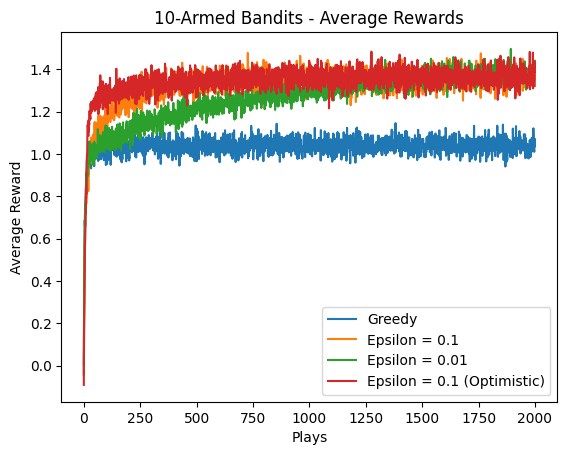

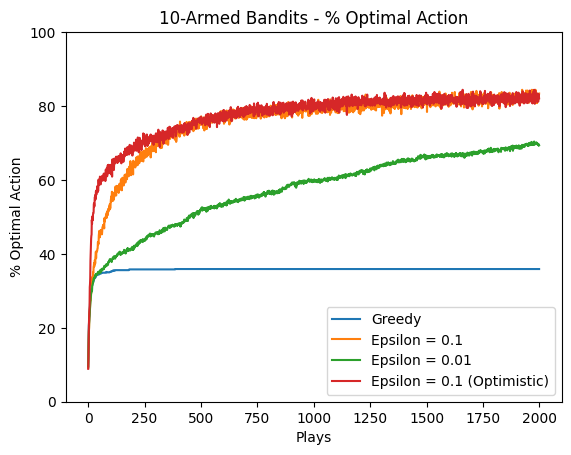

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt


class Environment:
    """
    This is what the bandits interact with. It contains both the possible rewards and the optimal answer.
    It also keeps track of the bandit's action, the reward it gave, and whether it was optimal.
    """
    def __init__(self) -> None:
        """
        Initialize tracking arrays and reset all bandits.
        """        
        self.rewardArray   = np.random.normal(mean, stdDev, numArms)
        self.optimalAction = np.argmax(self.rewardArray)
        
        for bandit in bandits: bandit.reset()        

    
    def play(self, play: int) -> None:
        """
        For every bandit, we get its choice and choose an appropriate randomish reward.
        We then update optimalArr and scoreArr based on the bandit's action and the reward given, respectively.
        """
        for banditIDX, bandit in enumerate(bandits):
            banditAction = bandit.choose()
            wasOptimal   = (banditAction == self.optimalAction)
         
            baseReward     = self.rewardArray[banditAction]
            gaussianReward = np.random.normal(baseReward, scale=1)
                
            optimalArr[play, banditIDX] += wasOptimal
            scoreArr[play, banditIDX]   += gaussianReward
            
            bandit.observe(gaussianReward)



class Bandit:
    """
    I'll fill in this docstring later, I'm going to bed
    """
    def __init__(self, epsilon: float, defaultValue: int=0) -> None:
        self.epsilon      = epsilon
        self.defaultValue = defaultValue
        self.action       = None

        self.reset()

    
    def __str__(self) -> str:
        """Choose an appropriate string representaion based on the bandit type"""
        optimistic = "" if not self.defaultValue else "(Optimistic)"
        if not self.epsilon: return "Greedy"
        return f"Epsilon = {self.epsilon} {optimistic}"

    
    def reset(self) -> None:
        """Reset all arrays needed to calculate Action-Value."""
        self.rewardSum      = np.zeros(numArms)
        self.actionCount    = np.zeros(numArms)

        self.actionValueArr = np.full(numArms, self.defaultValue, dtype=np.float64)

    
    def choose(self) -> int:
        """
        Get a random number in the range 0.0-1.0. If it's above our epsilon threshold,
        We exploit and pick the greedy option. Otherwise, we explore and pick a random option.
        (NOTE: Instead of returning the value directly, we save it in self.action to use later).
        """
        if np.random.random() > self.epsilon:
            self.action = np.argmax(self.actionValueArr)
        else:
            self.action = np.random.choice(numArms)
        
        return self.action

    
    def observe(self, reward: float) -> None:
        """
        After getting some reward, we update our estimates for the action we took
        by taking the average of the total reward for that action over however many times we've chosen that action.
        (After we update it with our observation of course)
        """
        self.actionCount[self.action]   += 1
        self.rewardSum[self.action]     += reward

        rewardAvg = self.rewardSum[self.action] / self.actionCount[self.action]
        self.actionValueArr[self.action] = rewardAvg



if __name__ == "__main__":
    # Begin tracking the execution time
    startTime = time.time()

    # Initialize essential variables
    numArms    = 10
    mean       = 0
    stdDev     = 1
    iterations = 1000
    plays      = 2000
    
    bandits = [
        Bandit(0),                     # Greedy
        Bandit(0.1),                   # Cautious
        Bandit(0.01),                  # Paranoid
        Bandit(0.1, defaultValue=1),   # Cautiously Optimistic
        #Bandit(0.01, defaultValue=1),  # Cautiously Paranoid
        #Bandit(0.05, defaultValue=0.5) # Balanced
    ]
    
    scoreArr   = np.zeros((plays, len(bandits)))
    optimalArr = np.zeros((plays, len(bandits)))

    # Begin main learning loop
    for iteration in range(iterations):
        env = Environment()
        
        if iteration % 100 == 0:
            print(f"Iteration {iteration}/{iterations}")
        
        for play in range(plays):
            env.play(play)                               
    
    avgScores  = scoreArr   / iterations
    avgOptimal = optimalArr / iterations
      
################################################################
## STATS TIME! ##
    
    print(f"Execution time: {time.time()-startTime} seconds")  

    # Average Reward Plot
    plt.title("10-Armed Bandits - Average Rewards")
    plt.plot(avgScores)
    plt.ylabel('Average Reward')
    plt.xlabel('Plays')
    plt.legend(bandits)
    plt.show()

    # Optimal Action % Plot
    plt.title("10-Armed Bandits - % Optimal Action")
    plt.plot(avgOptimal * 100)
    plt.ylim(0, 100)
    plt.ylabel('% Optimal Action')
    plt.xlabel('Plays')
    plt.legend(bandits)
    plt.show()
